<a href="https://colab.research.google.com/github/ramapriyakp/Portfolio/blob/master/NLP/Neural%20machine%20translator%20English-German%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Translation with Word Level seq2seq DL Models

The objective is to convert a German sentence (sequence of words) to English using a Neural Machine Translation (NMT) system based on word level encoder-decoder models.

![](https://i.imgur.com/So32H7U.png)

We will use German-English sentence pairs data from http://www.manythings.org/anki/


Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, language translation, text-to-speech, speech-to-text among others. Our aim is to translate german to english sentences.

Here, both, the input and output are sentences. In other words, these sentences are a sequence of words going in and out of our model.

![](https://i.imgur.com/Uk1tCPo.png)

A typical seq2seq model is also known as an encoder-decoder model and has 2 major components:
- The encoder 
- The decoder

Both these parts are essentially two different sequential models like RNNs\LSTMs which are combined together.

![](https://i.imgur.com/bT6PAtv.png)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/NLP

/content/drive/My Drive/NLP


Download the data and extract "deu.txt" in your working directory.

In [0]:
!wget http://www.manythings.org/anki/deu-eng.zip

--2019-09-09 07:30:59--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4541707 (4.3M) [application/zip]
Saving to: ‘deu-eng.zip.1’

deu-eng.zip.1       100%[===================>]   4.33M  15.1MB/s    in 0.3s    

2019-09-09 07:31:00 (15.1 MB/s) - ‘deu-eng.zip.1’ saved [4541707/4541707]



In [0]:
!unzip deu-eng.zip

Archive:  deu-eng.zip
replace deu.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##Import Required Libraries

In [0]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


# Load up the dataset

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [0]:
data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [0]:
deu_eng = deu_eng[:50000,:]

# Text Pre-Processing

**Text Cleaning**

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [0]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['The man died of cancer.', 'Der Mann starb an Krebs.'],
       ['The man lay motionless.', 'Der Mann lag bewegungslos da.'],
       ['The man must be insane.', 'Der Mann muss geistesgestört sein.']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [0]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['The man died of cancer', 'Der Mann starb an Krebs'],
       ['The man lay motionless', 'Der Mann lag bewegungslos da'],
       ['The man must be insane', 'Der Mann muss geistesgestört sein']],
      dtype='<U537')

In [0]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [0]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['the man died of cancer', 'der mann starb an krebs'],
       ['the man lay motionless', 'der mann lag bewegungslos da'],
       ['the man must be insane', 'der mann muss geistesgestört sein']],
      dtype='<U537')

##Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.





In [0]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [0]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

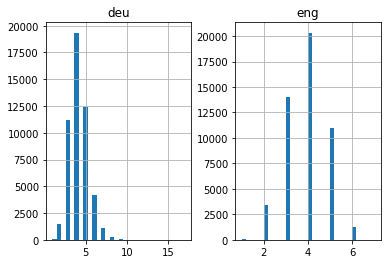

In [0]:

length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [0]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6352


In [0]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10678


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

##Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [0]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [0]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

# Build seq2seq Model Architecture
​
![](https://i.imgur.com/3ZVi97s.png)
​
- For the encoder, we will use an embedding layer and an LSTM layer
- For the decoder, we will use another LSTM layer followed by a dense layer
- Repeat Vector helps pass the output sequence from encoder to all LSTM cells in the decoder
​
We leverage the full power of GPUs by using the CUDA variant of the LSTM models.


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

##Seq2seq:
Seq2seq was introduced for machine translation, by Google. Before that, translation worked in a very naïve way. Each word typed was converted to its target language giving no regard to its grammar and sentence structure. Seq2seq revolutionized the process of translation by making use of deep learning. It not only takes the current word/input into account while translating but also its neighborhood.

Nowadays, it is used for a variety of different applications such as image captioning, conversational models, text summarization etc.

##Seq2seq Working:
As the name suggests, seq2seq takes as input a sequence of words(sentence or sentences) and generates an output sequence of words. It does so by use of the recurrent neural network (RNN). Although the vanilla version of RNN is rarely used, its more advanced version i.e. LSTM or GRU are used. This is because RNN suffers from the problem of vanishing gradient. LSTM is used in the version proposed by Google. It develops the context of the word by taking 2 inputs at each point of time. One from the user and other from its previous output, hence the name recurrent (output goes as input).

It mainly has two components i.e encoder and decoder, and hence sometimes it is called the Encoder-Decoder Network.

*  __Encoder__: It uses deep neural network layers and converts the input words to corresponding hidden vectors. Each vector represents the current word  
* __Decoder__: It is similar to the encoder. It takes as input the hidden vector generated by encoder, its own hidden states and current word to produce the next hidden vector and finally predict the next word.

Apart from these two, many optimizations have lead to other components of seq2seq:

**Attention:** The input to the decoder is a single vector which has to store all the information about the context. This becomes a problem with large sequences. Hence the attention mechanism is applied which allows the decoder to look at the input sequence selectively.

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [0]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Please note that we have used **'sparse_categorical_crossentropy'** as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

Now we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We  also  use **ModelCheckpoint()** to save the best model with lowest validation loss. I personally prefer this method over early stopping.

# Model Training

We save the model with minimum loss here also with checkpointing

In [0]:
filename = 'model.ge_en'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 21s 663us/step - loss: 3.5739 - val_loss: 3.0018

Epoch 00001: val_loss improved from inf to 3.00182, saving model to model.ge_en
Epoch 2/30
32000/32000 [==============================] - 15s 475us/step - loss: 2.9078 - val_loss: 2.8995

Epoch 00002: val_loss improved from 3.00182 to 2.89952, saving model to model.ge_en
Epoch 3/30
32000/32000 [==============================] - 15s 474us/step - loss: 2.7349 - val_loss: 2.6755

Epoch 00003: val_loss improved from 2.89952 to 2.67547, saving model to model.ge_en
Epoch 4/30
32000/32000 [==============================] - 15s 475us/step - loss: 2.5431 - val_loss: 2.5531

Epoch 00004: val_loss improved from 2.67547 to 2.55309, saving model to model.ge_en
Epoch 5/30
32000/32000 [==============================] - 15s 473us/step - loss: 2.3790 - val_loss: 2.4252

Epoch 00005: val_loss improved from 2.55309 to 2.42524, saving model to model.

Let's compare the training loss and the validation loss.

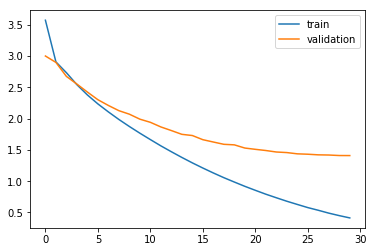

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

##Make Predictions

Let's load the saved model to make predictions.

In [0]:
model = load_model('model.ge_en')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pred_df.head(15)

,actual,predicted
0,he wanted to be rich,he wanted to rich
1,i love tom,i love tom
2,let us go home,lets go home
3,i love driving,i love like my
4,this is my dictionary,thats my dictionary
5,hi tom good morning,hi tom over
6,why is she so popular,why is so popular
7,ill show you my room,ill show you my room
8,did tom oversleep,did tom satisfied
9,keep up the good work,look good do


In [0]:
pred_df.tail(15)

,actual,predicted
9985,i didnt notice it,i wont care that
9986,she rode a camel,she took on a
9987,trust me he said,tell as i was
9988,tom grabbed his bag,tom has his hair
9989,what was tom like,how did tom like
9990,it looks like snow,it looks fine
9991,tom works slowly,tom works slowly
9992,i love rock,i like reading
9993,our tv isnt working,the door
9994,youre a racist,youre a workaholic


In [0]:
pred_df.sample(15)

,actual,predicted
1816,i come here every year,i come the every house
5200,we love this school,we love school
6612,step inside,go inside
6334,what can i do to help,how can i help you
4439,tom was sarcastic,tom went moving
1885,tom wasnt funny,tom wasnt funny
6710,dinner is ready,dinners is ready
3860,it sure is cold today,its all cold today
8954,whats your hobby,whats your hobby
781,im very forgetful,im very broadminded
